**Analysis of US Fair Use Claim Outcomes Project**

By: Anupam Sivaram

# Motivation for the Project

I've been very inspired by the advent of technology into the law: Estonia is now experimenting with ML-powered virtual judges for small claims (appealable to a human judge), and Thomas Reuters recently completed a $655mm acquisition of Casetext, which is built on top of GPT-4's API and, among other things, generates legal research and procedure. These progresses have the potential to greatly enhance certainty in legal outcomes, and test the boundaries between objectivity and subjectivity in our social order. 

With this project, I will investigate some of the issues that a legal prediction model would encounter when dealing with facts of a case. US fair use is an interesting area of law, because it generally follows the same 4-question framework, but outcomes vary widely. For example, sometimes a "substantial taking" of an original work will be fatal to a fair use claim, whereas in other cases, its finding is considered far less important than another aspect of the test. I believe that this investigation will ground the construction of solid prediction models that take these issues into account. 

# Initial Hypothesis and Questions to Answer

My initial hypothesis is:

*   Controlling for jurisdiction or issues faced in the case will not be sufficient to predict the outcome of a case.


I hope to answer the following questions by the end of this project:

1. For machine learning powered analyses of the law, what kinds of categorical or long-form text data can be converted to numerical data?
2. What might cause confusion for our prediction models in this area?
3. What kinds of prediction models generally perform well for this type of analysis? 

# Import Libraries

In [2]:
!pip install joblib
!pip install xgboost
import joblib
import json
print("Done.")

Done.


In [3]:
from IPython.utils import io

import numpy as np
import pywt
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (20,10)
import pandas as pd
import seaborn as sn

import os
import shutil

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

print("Done.")

Done.


# Data Collection: Import Raw Data

I obtained my data from this Kaggle set: https://www.kaggle.com/datasets/sujaykapadnis/copyrights-fair-use-index

Because it was quicker to do so manually, given that this set is quite small, I manually omitted any cases decided prior to 1977, to account for the implementation of the Copyright Act of 1976. 

In [19]:
df1 = pd.read_csv('/Users/anupamsivaram/Desktop/Amended Fair Use Findings.csv')
df1.head

<bound method NDFrame.head of                                                  title  \
0      N.Y. Times Co. v. Roxbury Data Interface, Inc.,   
1                   Walt Disney Prods. v. Air Pirates,   
2    Dall. Cowboys Cheerleaders, Inc. v. Scoreboard...   
3                 DC Comics Inc. v. Crazy Eddie, Inc.,   
4    Triangle Publ’ns, Inc. v. Knight-Ridder Newspa...   
..                                                 ...   
194                                Monsarrat v. Newman   
195       Bell v. Eagle Mt. Saginaw Indep. Sch. Distr.   
196                              De Fontbrune v. Wofsy   
197                     Viacom Int’l v. Pixi Universal   
198  Matthew Lombardo and Who’s Holiday LLC v. Dr. ...   

                                           case_number                 year  \
0                       434 F. Supp. 217 (D.N.J. 1977)                 1977   
1    581 F.2d 751 (9th Cir. 1978), cert. denied, 43...                 1978   
2                        600 F.2d 11

# Data Cleaning

At this stage, I will drop any unnecessary columns and create a new column to collect binary outcomes: Fair use was found, or it wasn't. 

In [22]:
# Reading the outcome column to see findings of Fair Use.

df1.shape
df1.groupby('outcome')['outcome'].agg('count')

outcome
Fair Use Found; mixed result                           1
Fair Use Not Found                                     1
Fair use found                                        95
Fair use found.                                        1
Fair use found; Second Circuit affirmed on appeal.     1
Fair use not found                                    94
Fair use not found, Preliminary ruling                 1
Fair use not found, preliminary ruling                 2
Fair use not found.                                    1
Fair use not found; Preliminary ruling                 2
Name: outcome, dtype: int64

In [24]:
import pandas as pd
import re

def categorize_outcome(text):
    text_lower = text.lower()
    
    if re.search(r'\bfair use found\b', text_lower):
        return '1'
    elif re.search(r'\bfair use not found\b', text_lower):
        return '0'
    else:
        return 'UNCATEGORIZED'

df1['outcome2'] = df1['outcome'].apply(categorize_outcome)

df1.groupby('outcome2')['outcome2'].agg('count')

outcome2
0    101
1     98
Name: outcome2, dtype: int64

In [25]:
df2 = df1.drop(['case_number','key_facts','issue','tags'],axis='columns')
df2.head

<bound method NDFrame.head of                                                  title                 year  \
0      N.Y. Times Co. v. Roxbury Data Interface, Inc.,                 1977   
1                   Walt Disney Prods. v. Air Pirates,                 1978   
2    Dall. Cowboys Cheerleaders, Inc. v. Scoreboard...                 1979   
3                 DC Comics Inc. v. Crazy Eddie, Inc.,                 1979   
4    Triangle Publ’ns, Inc. v. Knight-Ridder Newspa...                 1980   
..                                                 ...                  ...   
194                                Monsarrat v. Newman                 2022   
195       Bell v. Eagle Mt. Saginaw Indep. Sch. Distr.                 2022   
196                              De Fontbrune v. Wofsy                 2022   
197                     Viacom Int’l v. Pixi Universal                 2022   
198  Matthew Lombardo and Who’s Holiday LLC v. Dr. ...  2017, affirmed 2018   

                     

In [26]:
# As part of data cleaning, we'll ensure that no values have been omitted.

df2.isnull().sum()

df1.groupby('court')['court'].agg('count')

court
Supreme Court of the United States                                        4
U.S. District Court for the Eastern District of New York                  1
United State District Court for the District of Nevada                    1
United Stated Court of Appeals for the Second Circuit                     1
United States Court of Appeal for the Fifth Circuit                       1
United States Court of Appeal for the Second Circuit                      1
United States Court of Appeals for the Central District of California     1
United States Court of Appeals for the District of Columbia               1
United States Court of Appeals for the Eastern District of Virginia       1
United States Court of Appeals for the Eleventh Circuit                   5
United States Court of Appeals for the Federal Circuit                    1
United States Court of Appeals for the Fifth Circuit                      3
United States Court of Appeals for the First Circuit                      4
United

In [27]:
# Here, we'll combine any circuits that are the same.
# Our data only goes up to the 11th circuit. 

import pandas as pd
import re

def categorize_circuit(text):
    text_lower = text.lower()
    
    if re.search(r'\bsupreme court\b', text_lower):
        return 'Supreme Court'
    elif re.search(r'\bdistrict court\b', text_lower):
        return 'District Court'
    elif re.search(r'\bfirst circuit\b', text_lower):
        return 'First Circuit'
    elif re.search(r'\bsecond circuit\b', text_lower):
        return 'Second Circuit'
    elif re.search(r'\bthird circuit\b', text_lower):
        return 'Third Circuit'
    elif re.search(r'\bfourth circuit\b', text_lower):
        return 'Fourth Circuit'
    elif re.search(r'\bfifth circuit\b', text_lower):
        return 'Fifth Circuit'
    elif re.search(r'\bsixth circuit\b', text_lower):
        return 'Sixth Circuit'
    elif re.search(r'\bseventh circuit\b', text_lower):
        return 'Seventh Circuit'
    elif re.search(r'\beighth circuit\b', text_lower):
        return 'Eighth Circuit'
    elif re.search(r'\bninth circuit\b', text_lower):
        return 'Ninth Circuit'
    elif re.search(r'\btenth circuit\b', text_lower):
        return 'Tenth Circuit'
    elif re.search(r'\beleventh circuit\b', text_lower):
        return 'Eleventh Circuit'
    else:
        return 'UNCATEGORIZED'

df2['circuit'] = df2['court'].apply(categorize_circuit)

df2.groupby('circuit')['circuit'].agg('count')

circuit
District Court      100
Eleventh Circuit      5
Fifth Circuit         4
First Circuit         4
Fourth Circuit        6
Ninth Circuit        29
Second Circuit       32
Seventh Circuit       3
Sixth Circuit         4
Supreme Court         4
Tenth Circuit         1
Third Circuit         2
UNCATEGORIZED         5
Name: circuit, dtype: int64

In [28]:
# Looking for stragglers that missed my labels. 

df2[df2.circuit=='UNCATEGORIZED']

# It looks like these are subject matter jurisdictions that are not bound by geography.
# So, we can leave them alone in the Uncategorized circuit. 

,title,year,court,outcome,holding,outcome2,circuit
20,"Radji v. Khakbaz,",1985,United States Court of Appeals for the Distric...,Fair use not found,The court held that defendants’ unauthorized u...,0,UNCATEGORIZED
51,"Metro-Goldwyn-Mayer, Inc. v. Am. Honda Motor C...",1995,United States Court of Appeals for the Central...,Fair use not found,The court granted MGM a preliminary injunction...,0,UNCATEGORIZED
92,"Tavory v. NTP, Inc.,",2007,United States Court of Appeals for the Eastern...,Fair use found,The court held that the litigation-related con...,1,UNCATEGORIZED
105,"Gaylord v. United States,",2010,United States Court of Appeals for the Federal...,Fair use not found,The appellate court held that putting an image...,0,UNCATEGORIZED
158,Davidson v. United States,2018,United States Court of Federal Claims,Fair use not found,The court determined that the government’s use...,0,UNCATEGORIZED


In [30]:
# We'll do the same for the holdings. 
# We'll be looking for cases that discuss a certain issue pertaining to fair use. 
# This could be useful in research, to see where an issue was brought up but did not necessarily and unilaterally dictate the case's outcome.

def categorize_market(text):
    text_lower = text.lower()
    
    if re.search(r'\bmarket\b', text_lower):
        return 1
    else:
        return 0
    
def categorize_purpose(text):
    text_lower = text.lower()
    
    if re.search(r'\bpurpose\b', text_lower):
        return 1
    else:
        return 0
    
def categorize_transformative(text):
    text_lower = text.lower()
    
    if re.search(r'\btransformative\b', text_lower):
        return 1
    else:
        return 0
    
def categorize_commercial(text):
    text_lower = text.lower()
    
    if re.search(r'\bcommercial\b', text_lower):
        return 1
    else:
        return 0
    
def categorize_harm(text):
    text_lower = text.lower()
    
    if re.search(r'\bharm\b', text_lower):
        return 1
    else:
        return 0
    
df2['market'] = df2['holding'].apply(categorize_market)
df2['purpose'] = df2['holding'].apply(categorize_purpose)
df2['transformative'] = df2['holding'].apply(categorize_transformative)
df2['commercial'] = df2['holding'].apply(categorize_commercial)
df2['harm'] = df2['holding'].apply(categorize_harm)

print(df2.groupby('market')['market'].agg('count'))
print(df2.groupby('purpose')['purpose'].agg('count'))
print(df2.groupby('transformative')['transformative'].agg('count'))
print(df2.groupby('commercial')['commercial'].agg('count'))
print(df2.groupby('harm')['harm'].agg('count'))

market
0     32
1    167
Name: market, dtype: int64
purpose
0     70
1    129
Name: purpose, dtype: int64
transformative
0     86
1    113
Name: transformative, dtype: int64
commercial
0     93
1    106
Name: commercial, dtype: int64
harm
0    157
1     42
Name: harm, dtype: int64


# Model Preparation

We'll split the data for the model into both X and y. X will contain the relevant image data and y will contain the response variable.

Afterwards, we will split 80% of the data into training data, and 20% into test data.

Here, I run a Pipeline prediction model to test. 

In [42]:
'''We will now build our prediction model.
A test size of 0.2 ensures that 20% of our sample will be used for testing.'''

X = df2[['market', 'purpose', 'transformative', 'commercial', 'harm']]
y = df2['outcome2']

y_train = y_train.astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.55

# Model Building and Tuning

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import pandas as pd

y_train = y_train.astype(int)

model_params = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'lasso': {
        'model': Lasso(),
        'params': {}
    },
    'svm': {
        'model': SVC(probability=True),
        'params': {
            'svc__C': [1, 10, 100, 1000],
            'svc__kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5, 10]
        }
    },
    'naive_bayes': {
        'model': GaussianNB(),
        'params': {}
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(random_state=1),
        'params': {
            'decisiontreeclassifier__max_depth': [None, 5, 10]
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'kneighborsclassifier__n_neighbors': [3, 5, 7],
            'kneighborsclassifier__weights': ['uniform', 'distance']
        }
    },
    'xgboost': {
        'model': XGBClassifier(),
        'params': {
            'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
            'xgbclassifier__n_estimators': [50, 100, 200]
        }
    }
}

scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

scoreResults = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
scoreResults

,model,best_score,best_params
0,linear_regression,0.008144,{}
1,lasso,-0.002408,{}
2,svm,0.584677,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
3,random_forest,0.578629,{'randomforestclassifier__n_estimators': 5}
4,logistic_regression,0.571976,{'logisticregression__C': 1}
5,naive_bayes,0.553427,{}
6,decision_tree,0.566129,{'decisiontreeclassifier__max_depth': None}
7,knn,0.559677,"{'kneighborsclassifier__n_neighbors': 7, 'knei..."
8,xgboost,0.603629,"{'xgbclassifier__learning_rate': 0.01, 'xgbcla..."


In [57]:
best_estimators['svm'].score(X_test.astype(int), y_test.astype(int))

0.55

In [58]:
best_estimators['random_forest'].score(X_test.astype(int), y_test.astype(int))

0.525

In [59]:
best_estimators['logistic_regression'].score(X_test.astype(int),y_test.astype(int))

0.575

In [60]:
best_estimators['xgboost'].score(X_test.astype(int),y_test.astype(int))

0.5

In [62]:
best_clf = best_estimators['xgboost']

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.astype(int), best_clf.predict(X_test.astype(int)))
cm

array([[13,  1],
       [19,  7]])

Text(95.72222222222221, 0.5, 'Truth')

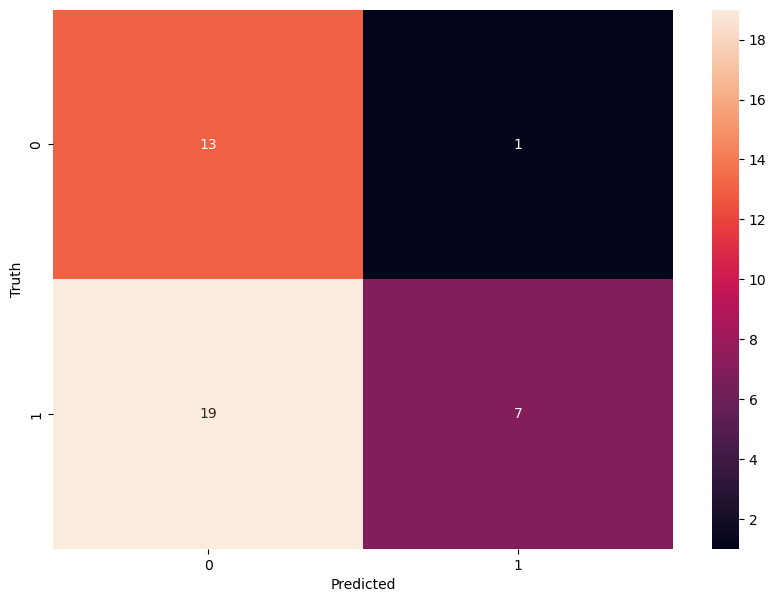

In [63]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Key Takeaways

**My initial hypothesis was proven to be correct**, that controlling for jurisdiction or issues faced in a fair use related case would not be sufficient to predict the outcome. That said, this investigation produced lots of useful information for the construction of prediction models that would work better.

The questions asked in the beginning of the project are answered below:

1. **For machine learning powered analyses of the law, what kinds of categorical or long-form text data can be converted to numerical data?**

    I was pleasantly surprised to learn about the re method for this analysis, which allowed me to easily condense jurisdictions into their respective circuits, bring outcomes down to binary data, and most importantly, extract information about the issues considered in a holding. Case judgements can run around 50-80 pages, and for the construction of accurate prediction models, we'll need a way to condense these judgements into easily accessible outcomes. I believe that this can be done. Much of my study in law school was taking a judgement that held in that long range and condensing it down to its most salient points, which typically managed to capture most of the law discussed in a minutia of the space. 

2. **What might cause confusion for our prediction models in this area?**

    Regarding differences in jurisdiction, as observed above, this training set had minimal samples per location and did not serve as a convincing marker of how outcomes change when varying jurisdiction. Thus, I chose not to train the data on this basis, as I knew that even if a model appeared to have predictive ability, its sources would not be valid. A better model would use a much larger sample size for each jurisdiction. 

    I did choose to predict on the basis of issues considered in the case, using dummy variables assigned to markers like a "transformative" use of the work; minimal market "harm" to the original, etc. Surprisingly, my models returned close to a 60% predictive ability, which is not far from a predictive ability of 70% achieved in a much more sophisticated model by Katz et al (2017), https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5389610/, used to predict Supreme Court case outcomes. A fatal flaw in these determinations was the fact that while these issues were mentioned, the model did not check HOW these issues were discussed. This metric was difficult to assess, as dealing with several different jurisdictions and therefore a multitude of authors, it was difficult to find specific speech patterns that would lend themselves to a certain outcome. A better model would therefore employ Natural Language Processing to assess the speech patterns and connotations of the portion of holdings concerning fair use. 

    Additionally, the small sample size of this dataset made me curious as to its source, given that there are definitely more than a few copyright cases a year. I realized, through recognizing the formatting, that this dataset had been scraped from summaries provided by the US Copyright Office, at https://www.copyright.gov/fair-use/. A feature of the limited cases selected by the Copyright Office in this set is their innovation on the law; these cases, in particular, are therefore made more difficult to predict than others because they do something differently. A better model would train with similar cases that have not entailed large-scale changes in the law. I suspect that this is why SCOTUS prediction models can perform well but imperfectly, as each case in that bracket necessarily entails a large change in the law, and the observation is made unique. 

3. **What kinds of prediction models generally perform well for this type of analysis?**

    Surprisingly, all of the models I tested (with the exception of Linear Regression and Lasso, which I expected to do poorly on this kind of data) performed similarly, with predictive ability around the 60% mark. I believe that XGBoost did slightly better than others due to its tree pruning feature, allowing the model to iterate and isolate the most important nodes within the list of Fair Use issues that come up. As mentioned, while the 4-question framework remains the same in fair use calculations, certain facets of the framework are often given more importance than others. 